## Imports

In [2]:
import pandas as pd  
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier  
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


## Read Data

In [3]:
df = pd.read_csv("data/train.csv")

## Data Preview 

In [4]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


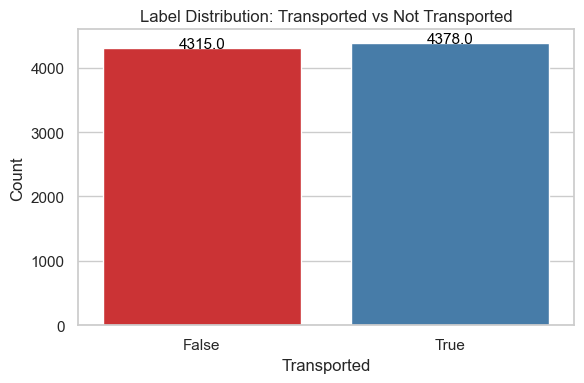

In [5]:
# Set the style
sns.set(style="whitegrid")

# Plot the distribution of the 'Transported' column
plt.figure(figsize=(6, 4))
sns.countplot(x='Transported', hue='Transported', data=df, palette='Set1', legend=False)

# Add labels and title
plt.title('Label Distribution: Transported vs Not Transported')
plt.xlabel('Transported')
plt.ylabel('Count')

# Show values on top of bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height()}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='baseline', fontsize=11, color='black')

plt.tight_layout()
plt.show()

## Gathering Features 

In [6]:

feature_cols = ['PassengerId',	'HomePlanet',	'CryoSleep',	'Cabin',	'Destination',	'Age',	'VIP',	'RoomService',	
'FoodCourt',	'ShoppingMall',	'Spa',	'VRDeck']
y = df['Transported']



## Fixing Data

In [7]:
X = pd.get_dummies(df[feature_cols])
X = X.fillna(0) 


## Data Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)


## Prediction/Accuracy

In [9]:
my_RandomForest = RandomForestClassifier(n_estimators=100, bootstrap=True, random_state=2)
my_RandomForest.fit(X_train, y_train)

y_predict = my_RandomForest.predict(X_test)
y_prob = my_RandomForest.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_predict)

auc_rf = roc_auc_score(y_test, y_prob)

print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")

print(f"AUC of Random Forest: {auc_rf:.4f}")

Accuracy of Random Forest: 0.7844
AUC of Random Forest: 0.8522


## Sorting by Importance

In [11]:
importances = my_RandomForest.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))

                         Feature  Importance
4                            Spa    0.060044
5                         VRDeck    0.053971
8702             CryoSleep_False    0.053279
1                    RoomService    0.046862
2                      FoodCourt    0.046674
8703              CryoSleep_True    0.044574
3                   ShoppingMall    0.039439
0                            Age    0.031070
8700           HomePlanet_Europa    0.014017
8699            HomePlanet_Earth    0.013460
8701             HomePlanet_Mars    0.005760
15264    Destination_55 Cancri e    0.004826
15266    Destination_TRAPPIST-1e    0.004498
15265  Destination_PSO J318.5-22    0.002389
15267                  VIP_False    0.002028
15268                   VIP_True    0.001068
15231              Cabin_G/981/S    0.000736
13305             Cabin_G/1026/P    0.000677
10111                Cabin_E/0/S    0.000654
10196              Cabin_E/158/P    0.000568


## Plotting 

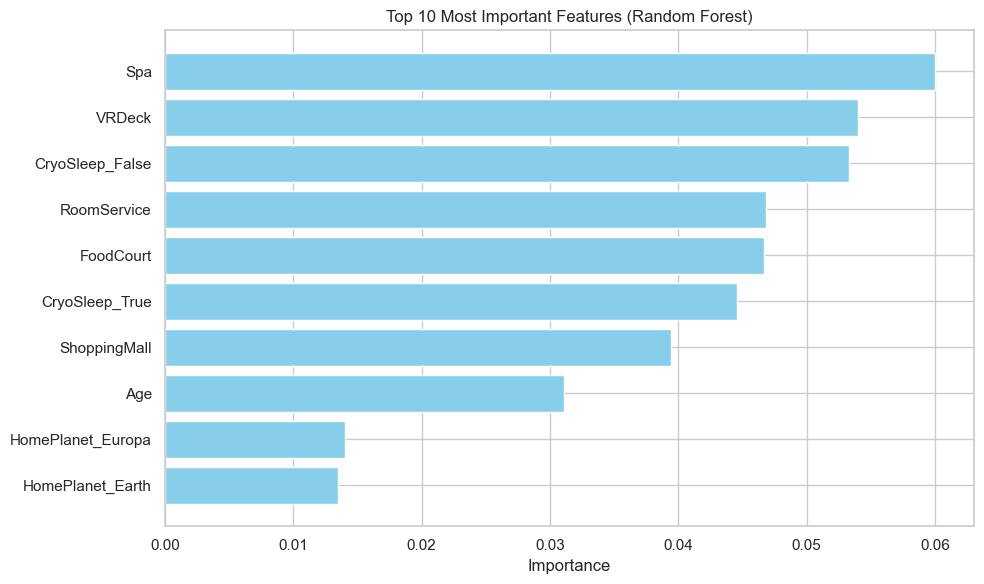

In [12]:

top_n = 10
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(top_n, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Most Important Features (Random Forest)')
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


In [13]:
# Print classification report (precision, recall, F1-score)
report = classification_report(y_test, y_predict, output_dict=True)

# Convert to a DataFrame for pretty display
df_report = pd.DataFrame(report).transpose()
df_report.style.background_gradient(cmap='Blues').format(precision=2)

,precision,recall,f1-score,support
False,0.78,0.78,0.78,861.00
True,0.79,0.79,0.79,878.00
accuracy,0.78,0.78,0.78,0.78
macro avg,0.78,0.78,0.78,1739.00
weighted avg,0.78,0.78,0.78,1739.00


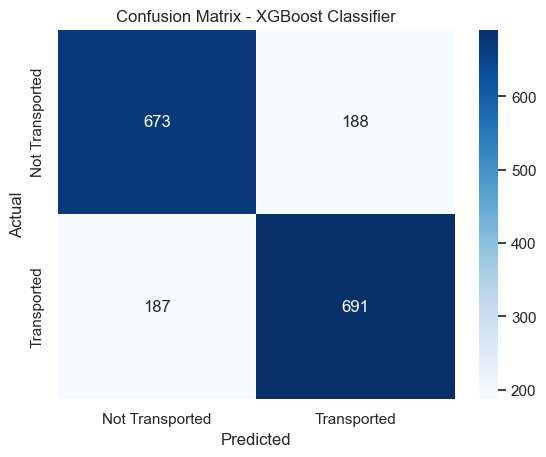

In [14]:
# Print Confusion Matrix
cm = confusion_matrix(y_test, y_predict)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Transported', 'Transported'], yticklabels=['Not Transported', 'Transported'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()